# Sección 1: Importar Librerías y Configuracion




In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

tf.random.set_seed(42)
print(f"🔥 TensorFlow versión: {tf.__version__}")

🔥 TensorFlow versión: 2.18.0


# Sección 2: Crear Dataset Sintético de Videojuegos

In [10]:
np.random.seed(42)
generos = ['Acción', 'RPG', 'Deportes', 'Puzzle', 'Horror', 'Aventura']
plataformas = ['PC', 'PlayStation', 'Xbox', 'Nintendo', 'Mobile']

data = []
for i in range(800):
    genero = np.random.choice(generos)
    plataforma = np.random.choice(plataformas)
    año = np.random.randint(2015, 2024)
    calificacion = np.random.uniform(6.0, 9.5)
    horas = np.random.randint(5, 80)

    # Lógica para precio
    precio = 20
    if genero in ['RPG', 'Acción']: precio += 25
    if genero in ['Aventura']: precio += 15
    if plataforma in ['PC', 'PlayStation', 'Xbox']: precio += 15
    if plataforma == 'Mobile': precio -= 10
    precio += (año - 2015) * 2.5
    precio += (calificacion - 6) * 10
    precio += horas * 0.4
    precio += np.random.normal(0, 8)
    precio = max(8, precio)

    data.append({
        'genero': genero,
        'plataforma': plataforma,
        'año': año,
        'calificacion': round(calificacion, 1),
        'horas': horas,
        'precio': round(precio, 2)
    })

df = pd.DataFrame(data)
print(f"📊 Dataset creado: {df.shape}")
print("\n🎮 Primeros 5 juegos:")
print(df.head())

📊 Dataset creado: (800, 6)

🎮 Primeros 5 juegos:
     genero   plataforma   año  calificacion  horas  precio
0    Puzzle       Mobile  2022           8.1     79   63.97
1  Deportes       Mobile  2016           8.5     34   47.43
2  Aventura  PlayStation  2019           8.2     62   85.51
3    Acción         Xbox  2017           7.3     68  113.19
4    Acción         Xbox  2019           8.1     25   98.92


# Sección 3: Preparar Datos


In [11]:
# Codificar variables categóricas
le_genero = LabelEncoder()
le_plataforma = LabelEncoder()

df['genero_cod'] = le_genero.fit_transform(df['genero'])
df['plataforma_cod'] = le_plataforma.fit_transform(df['plataforma'])

print(f"✅ Géneros: {le_genero.classes_}")
print(f"✅ Plataformas: {le_plataforma.classes_}")

# Preparar características y objetivo
features = ['genero_cod', 'plataforma_cod', 'año', 'calificacion', 'horas']
X = df[features].values.astype(np.float32)
y = df['precio'].values.astype(np.float32)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"📏 Forma de entrenamiento: {X_train_scaled.shape}")
print(f"📏 Forma de prueba: {X_test_scaled.shape}")
print(f"🎯 Rango de precios: ${y.min():.2f} - ${y.max():.2f}")


✅ Géneros: [np.str_('Acción') np.str_('Aventura') np.str_('Deportes')
 np.str_('Horror') np.str_('Puzzle') np.str_('RPG')]
✅ Plataformas: [np.str_('Mobile') np.str_('Nintendo') np.str_('PC')
 np.str_('PlayStation') np.str_('Xbox')]
📏 Forma de entrenamiento: (640, 5)
📏 Forma de prueba: (160, 5)
🎯 Rango de precios: $11.71 - $147.37


# Sección 4: Crear Red Neuronal

In [12]:
# Crear modelo secuencial
print("🏗️ Construyendo red neuronal con TensorFlow...")

model = keras.Sequential([
    # Capa de entrada
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), name='entrada'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Capas ocultas
    layers.Dense(32, activation='relu', name='oculta_1'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(16, activation='relu', name='oculta_2'),
    layers.Dropout(0.1),

    # Capa de salida
    layers.Dense(1, activation='linear', name='salida')
])

# Compilar modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Mostrar arquitectura
print("🏛️ Arquitectura del modelo:")
model.summary()

🏗️ Construyendo red neuronal con TensorFlow...
🏛️ Arquitectura del modelo:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta_1 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta_2 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 192 (768.00 B)

# Sección 5: Entrenar Red Neuronal

🚀 Entrenando la red neuronal...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7335.9961 - mae: 82.6212 - val_loss: 7213.1914 - val_mae: 82.0113 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7240.0532 - mae: 82.0866 - val_loss: 7191.4062 - val_mae: 81.8847 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7175.0322 - mae: 81.7406 - val_loss: 7165.7256 - val_mae: 81.7351 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7084.7949 - mae: 81.2242 - val_loss: 7130.6260 - val_mae: 81.5326 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7006.8779 - mae: 80.7657 - val_loss: 7083.0215 - val_mae: 81.2591 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6900.0464 - mae: 80.1524 - val_loss: 7018.5767 - val_mae: 80.8924 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6808.3442 - m

<ipython-input-13-3014915361>:42: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-3014915361>:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


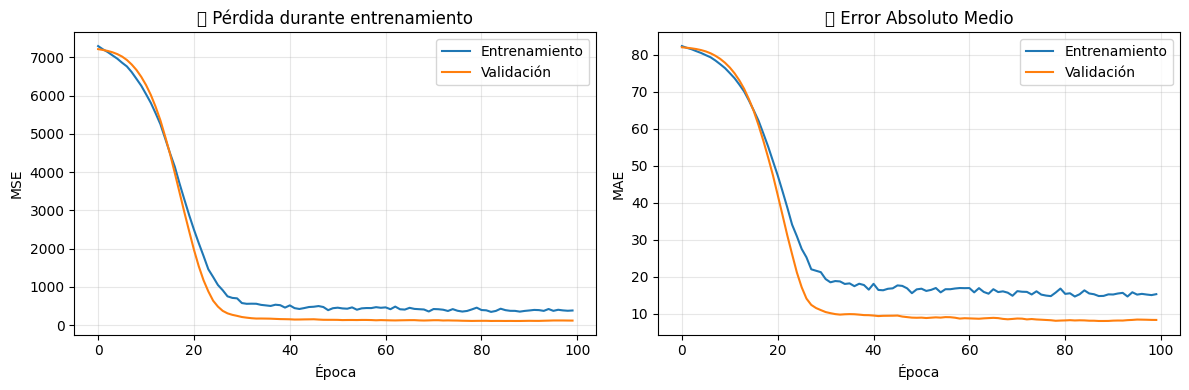

In [13]:
# Callbacks para mejorar entrenamiento
callbacks = [
    keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, min_lr=1e-6)
]

print("🚀 Entrenando la red neuronal...")

# Entrenar modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("✅ Entrenamiento completado!")

# Visualizar curvas de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('📉 Pérdida durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('📊 Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sección 6: Evaluar y Visualizar

🔮 Evaluando modelo...
📊 RESULTADOS:
🏋️ Entrenamiento - R²: 0.828, RMSE: $9.30
🧪 Prueba - R²: 0.837, RMSE: $9.42


<ipython-input-14-1428336163>:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-1428336163>:34: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


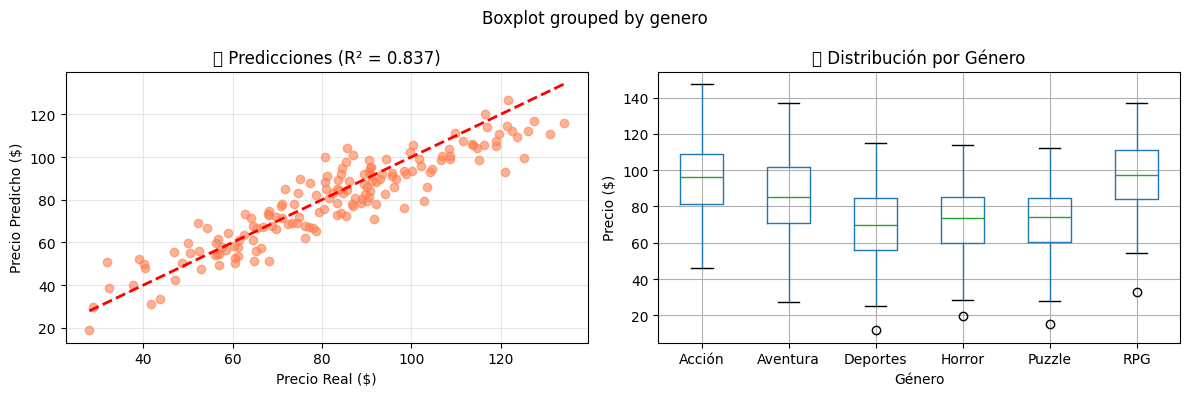


🎮 Ejemplos de predicciones:
Juego 1: Real=$102.17, Predicho=$95.78, Error=$6.39
Juego 2: Real=$108.77, Predicho=$100.72, Error=$8.05
Juego 3: Real=$83.73, Predicho=$84.38, Error=$0.65
Juego 4: Real=$77.91, Predicho=$66.56, Error=$11.35
Juego 5: Real=$123.63, Predicho=$109.24, Error=$14.39


In [14]:
# Hacer predicciones
print("🔮 Evaluando modelo...")

y_train_pred = model.predict(X_train_scaled, verbose=0)
y_test_pred = model.predict(X_test_scaled, verbose=0)

# Calcular métricas
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("📊 RESULTADOS:")
print(f"🏋️ Entrenamiento - R²: {train_r2:.3f}, RMSE: ${train_rmse:.2f}")
print(f"🧪 Prueba - R²: {test_r2:.3f}, RMSE: ${test_rmse:.2f}")

# Visualizar predicciones
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred.flatten(), alpha=0.6, color='coral')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real ($)')
plt.ylabel('Precio Predicho ($)')
plt.title(f'🎯 Predicciones (R² = {test_r2:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
df.boxplot(column='precio', by='genero', ax=plt.gca())
plt.title('💰 Distribución por Género')
plt.xlabel('Género')
plt.ylabel('Precio ($)')

plt.tight_layout()
plt.show()

# Mostrar ejemplos
print("\n🎮 Ejemplos de predicciones:")
indices = np.random.choice(len(X_test), 5, replace=False)
for i, idx in enumerate(indices):
    real = y_test[idx]
    pred = y_test_pred[idx][0]
    print(f"Juego {i+1}: Real=${real:.2f}, Predicho=${pred:.2f}, Error=${abs(real-pred):.2f}")

#Sección 7: Función de Predicción Interactiva

In [15]:
def predecir_precio_tensorflow(genero, plataforma, año, calificacion, horas):
    """Predice precio usando el modelo de TensorFlow"""

    print("🎮 PREDICTOR CON TENSORFLOW")
    print("="*35)

    try:
        # Codificar variables
        gen_cod = le_genero.transform([genero])[0]
        plat_cod = le_plataforma.transform([plataforma])[0]

        # Crear entrada
        entrada = np.array([[gen_cod, plat_cod, año, calificacion, horas]], dtype=np.float32)
        entrada_scaled = scaler.transform(entrada)

        # Predecir con TensorFlow
        precio_pred = model.predict(entrada_scaled, verbose=0)[0][0]

        print(f"📊 Características:")
        print(f"   • Género: {genero}")
        print(f"   • Plataforma: {plataforma}")
        print(f"   • Año: {año}")
        print(f"   • Calificación: {calificacion}/10")
        print(f"   • Horas de juego: {horas}")

        print(f"\n💰 Precio predicho: ${precio_pred:.2f}")

        # Categorizar precio
        if precio_pred < 25:
            categoria = "💚 Económico"
        elif precio_pred < 50:
            categoria = "💛 Precio medio"
        else:
            categoria = "🔥 Premium"

        print(f"📈 Categoría: {categoria}")

        return precio_pred

    except Exception as e:
        print(f"❌ Error: {e}")
        print(f"Géneros válidos: {list(le_genero.classes_)}")
        print(f"Plataformas válidas: {list(le_plataforma.classes_)}")

# Ejemplos de uso
print("🎯 EJEMPLOS CON TENSORFLOW:")
print("="*30)

predecir_precio_tensorflow('RPG', 'PlayStation', 2023, 9.1, 60)
print()
predecir_precio_tensorflow('Puzzle', 'Mobile', 2022, 7.8, 12)
print()
predecir_precio_tensorflow('Acción', 'PC', 2023, 8.5, 35)

🎯 EJEMPLOS CON TENSORFLOW:
🎮 PREDICTOR CON TENSORFLOW
📊 Características:
   • Género: RPG
   • Plataforma: PlayStation
   • Año: 2023
   • Calificación: 9.1/10
   • Horas de juego: 60

💰 Precio predicho: $119.90
📈 Categoría: 🔥 Premium

🎮 PREDICTOR CON TENSORFLOW
📊 Características:
   • Género: Puzzle
   • Plataforma: Mobile
   • Año: 2022
   • Calificación: 7.8/10
   • Horas de juego: 12

💰 Precio predicho: $56.96
📈 Categoría: 🔥 Premium

🎮 PREDICTOR CON TENSORFLOW
📊 Características:
   • Género: Acción
   • Plataforma: PC
   • Año: 2023
   • Calificación: 8.5/10
   • Horas de juego: 35

💰 Precio predicho: $110.59
📈 Categoría: 🔥 Premium


np.float32(110.59442)

# Sección 8: Conclusiones y Guardado


In [16]:
print("🎓 RESUMEN FINAL")
print("="*20)

print(f"🤖 Modelo: Red Neuronal con TensorFlow")
print(f"📊 Precisión: {test_r2:.1%}")
print(f"💰 Error promedio: ${test_rmse:.2f}")
print(f"🏗️ Arquitectura: 64→32→16→1 neuronas")

if test_r2 > 0.8:
    resultado = "🎉 ¡Excelente modelo!"
elif test_r2 > 0.6:
    resultado = "👍 Buen rendimiento"
else:
    resultado = "⚠️ Necesita mejoras"

print(f"🎯 Evaluación: {resultado}")

# Guardar modelo (opcional)
print("\n💾 Guardando modelo...")
model.save('modelo_precios_videojuegos.h5')
print("✅ Modelo guardado como 'modelo_precios_videojuegos.h5'")

print("\n🚀 Ventajas de TensorFlow:")
print("• Mejor control del entrenamiento")
print("• Callbacks para optimización automática")
print("• Normalización por lotes")
print("• Dropout para evitar sobreajuste")
print("• Fácil guardado y carga de modelos")

print("\n🎮 ¡Modelo listo para predecir precios!")

🎓 RESUMEN FINAL
🤖 Modelo: Red Neuronal con TensorFlow
📊 Precisión: 83.7%
💰 Error promedio: $9.42
🏗️ Arquitectura: 64→32→16→1 neuronas
🎯 Evaluación: 🎉 ¡Excelente modelo!

💾 Guardando modelo...
✅ Modelo guardado como 'modelo_precios_videojuegos.h5'

🚀 Ventajas de TensorFlow:
• Mejor control del entrenamiento
• Callbacks para optimización automática
• Normalización por lotes
• Dropout para evitar sobreajuste
• Fácil guardado y carga de modelos

🎮 ¡Modelo listo para predecir precios!
